In [4]:
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [5]:
# %load_ext autoreload
# %autoreload 2

In [6]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.special import expit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#import plotly.subplots as sp
#import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [7]:
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [8]:
speed_cols = [
    "a1_kedaung_speed_kt",
    "a2_airnav_tower_710_speed_kt",
    "a3_airnav_tower_720_speed_kt",
    "a4_pintu_kapuk_speed_kt",
    "a5_bmkg_old_llwas_tower_2_speed_kt",
    "a6_batu_ceper_speed_kt",
    "a7_benda_speed_kt",
    "a8_bayur_speed_kt",
    "a9_rawa_burung_speed_kt",
    "a10_kelor_speed_kt",
    "a11_comm_tower_speed_kt",
    "a12_bmkg_old_llwas_tower_1_speed_kt",
]

direction_cols = [
    "a1_kedaung_dir_deg", 
    "a2_airnav_tower_710_dir_deg",
    "a3_airnav_tower_720_dir_deg",
    "a4_pintu_kapuk_dir_deg",
    "a5_bmkg_old_llwas_tower_2_dir_deg",
    "a6_batu_ceper_dir_deg",
    "a7_benda_dir_deg",
    "a8_bayur_dir_deg",
    "a9_rawa_burung_dir_deg",
    "a10_kelor_dir_deg",
    "a11_comm_tower_dir_deg",
    "a12_bmkg_old_llwas_tower_1_dir_deg"    
]

target_cols = [
    "rwy_07la", "rwy_25rd", "rwy_25ra", "rwy_07ld",
    "rwy_07ra", "rwy_25ld", "rwy_25la", "rwy_07rd"
]

In [9]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class TemporalBlock(nn.Module):
    """
    A class representing a temporal block used in Temporal Convolutional Networks (TCNs).

    Args:
    - n_inputs (int): the number of input channels
    - n_outputs (int): the number of output channels
    - kernel_size (int): the size of the convolutional kernel
    - stride (int): the stride used in convolution
    - dilation (int): the dilation used in convolution
    - padding (int): the padding used in convolution
    - dropout (float): the dropout probability

    Attributes:
    - conv1 (torch.nn.Conv2d): the first convolutional layer
    - pad (torch.nn.ZeroPad2d): the zero-padding layer
    - relu (torch.nn.ReLU): the activation function
    - dropout (torch.nn.Dropout): the dropout layer
    - conv2 (torch.nn.Conv2d): the second convolutional layer
    - net (torch.nn.Sequential): the sequence of layers composing the temporal block
    - downsample (torch.nn.Conv1d): the optional downsample layer
    - relu (torch.nn.ReLU): the activation function
    """
    
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        """
        Initializes the weights of the convolutional layers using normal distribution with mean 0 and standard
        deviation 0.01.
        """        
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        """
        Performs a forward pass through the temporal block.

        Args:
        - x (torch.Tensor): the input tensor of shape (batch_size, input_channels, sequence_length)

        Returns:
        - out (torch.Tensor): the output tensor of shape (batch_size, output_channels, sequence_length)
        """        
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    """
    The TemporalConvNet class is a PyTorch module that implements a temporal convolutional
    network for sequence forecasting tasks.

    Args:
    - num_inputs (int): The number of input features.
    - num_channels (List[int]): A list of integers representing the number of channels in each convolutional layer.
    - kernel_size (int, optional): The kernel size of the convolutional layers. Default is 2.
    - dropout (float, optional): The dropout rate to apply after each convolutional layer. Default is 0.2.

    Attributes:
    - network (nn.Sequential): A PyTorch sequential module containing the TemporalBlock layers.
    """
    def __init__(self, num_inputs, num_channels, input_length=60, output_length=1, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(input_length*num_channels[-1], output_length)

    def forward(self, x):
        x = self.network(x)
        return self.fc(x.reshape(x.shape[0], -1)).flatten()

In [10]:
%%time

# load data
DATA_PATH = "C:/Users/ejhas/Downloads/Algoritma/6-classification_in_machine_learning_i-main"
observations = pd.read_csv(f"{DATA_PATH}/data/observations.csv", low_memory=False)
warnings = pd.read_csv(f"{DATA_PATH}/data/warnings.csv", low_memory=False)

# convert to datetime
observations["time"] = pd.to_datetime(observations["time"])
warnings["time"] = pd.to_datetime(warnings["time"])

# combine data
observations = observations.merge(warnings, on="time")
del warnings

# create indicator for warnings
for x in target_cols:
    observations[x] = (~observations[x].str.contains("NIL|///")).astype(np.int32)
    
# resample every 10s
observations = observations.set_index("time").resample("10S").mean()

# Calculate the target variable
for x in target_cols:
    target = pd.Series(np.zeros(len(observations)), index=observations[x].index)
    for i in range(15*6):
        target += observations[x].shift(-(360 + i)).values
    observations[x] = (target > 0).astype(np.int32)
    
# find rows that are okay to use as a sequence
seq_ok = pd.Series(np.zeros(len(observations)), index=observations.index)
seq_ok.iloc[:60] = -1

for x in tqdm.tqdm(speed_cols + direction_cols, desc="Find valid sequences"):
    series = ~observations[x].isna()
    seq_ok += series.rolling(window=60, min_periods=1).apply(np.all, raw=True)    
observations["is_valid_seq"] = (seq_ok == 24.0)    

# get x-y comonents of wind speed
feature_cols = []
for s_col,d_col in zip(speed_cols, direction_cols):
    theta = -np.pi*(observations[d_col] - 90)/180
    observations[f"{s_col}_x"] = observations[s_col] * np.cos(theta)
    observations[f"{s_col}_y"] = observations[s_col] * np.sin(theta)
    feature_cols.extend([f"{s_col}_x", f"{s_col}_y"])
    
# collect features and targets into arrays
features, targets = [], []
for i in tqdm.tqdm(np.where(observations.is_valid_seq)[0], desc="Collect features and targets"):
    features.append(observations.iloc[i-60+1:i+1][feature_cols].values)
    targets.append(observations.iloc[i][target_cols].values)
features = np.array(features, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

Collect features and targets: 100%|███████████████████████████████████████████| 102190/102190 [06:27<00:00, 264.01it/s]


CPU times: total: 5min 44s
Wall time: 8min 15s


In [16]:
# split data into train and test
target_num = 2
trn_idx, val_idx = train_test_split(np.arange(len(features)), test_size=0.2, stratify=targets[:, target_num])
trn_idx = np.append(
    np.random.choice(trn_idx[targets[trn_idx, target_num] == 0], 1000),
    trn_idx[targets[trn_idx, target_num] == 1]
)

trn_features, trn_targets = features[trn_idx], targets[trn_idx, target_num]
val_features, val_targets = features[val_idx], targets[val_idx, target_num]

trn_dataset = TensorDataset(torch.tensor(trn_features), torch.tensor(trn_targets))
val_dataset = TensorDataset(torch.tensor(val_features), torch.tensor(val_targets))

trn_loader = DataLoader(trn_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
#x.shape, y.shape

AttributeError: 'str' object has no attribute 'shape'

Epoch 1/10, Average Loss: 0.5176
Epoch 2/10, Average Loss: 0.2112
Epoch 3/10, Average Loss: 0.1416
Epoch 4/10, Average Loss: 0.1096
Epoch 5/10, Average Loss: 0.0871
Epoch 6/10, Average Loss: 0.0728
Epoch 7/10, Average Loss: 0.0652
Epoch 8/10, Average Loss: 0.0596
Epoch 9/10, Average Loss: 0.0545
Epoch 10/10, Average Loss: 0.0506


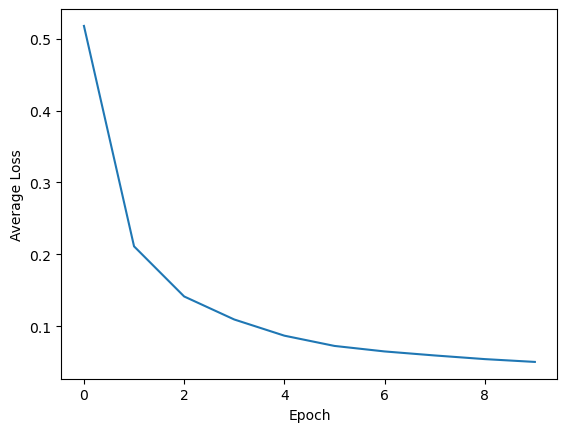

In [17]:
# Initialize the model, loss function, and optimizer
seed_everything(0)

model = TemporalConvNet(24, num_channels=[16, 8, 4])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
num_epochs = 10
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (x, y) in enumerate(trn_loader):
        
        # Forward pass
        preds = model(x.permute(0, 2, 1))
        loss = criterion(preds, y)
        epoch_loss += loss.item() / len(trn_loader)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    # Print the average loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}")
    epoch_losses.append(epoch_loss)
         
# Plot the average loss over time
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()        

In [18]:
# Evaluate the model on the test set
results =  []
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        preds = model(x.permute(0, 2, 1))
        results.append(pd.DataFrame(dict(
            targets=y.numpy().flatten(),
            predictions=preds.numpy().flatten(),
        )))
        
results = pd.concat(results, ignore_index=True)

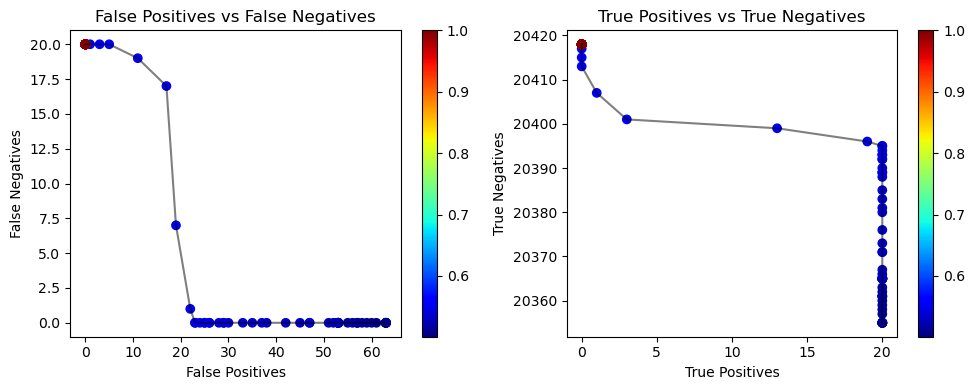

In [19]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

# Create a sample binary target series and predicted probabilities series
target = results.targets
probs = expit(results.predictions)

# Compute accuracy for each possible threshold value
thresholds = np.linspace(0.5, 1, 501)[1:]
tp = np.array([np.sum((target==1) & (probs >= t)) for t in thresholds])
tn = np.array([np.sum((target==0) & (probs < t)) for t in thresholds])
fp = np.array([np.sum((target==0) & (probs >= t)) for t in thresholds])
fn = np.array([np.sum((target==1) & (probs < t)) for t in thresholds])

# Plot false positives vs false negatives parameterized by classification threshold
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(fp, fn, c=thresholds, cmap="jet")
plt.plot(fp, fn, "k-", alpha=0.5)
plt.colorbar()
plt.xlabel("False Positives")
plt.ylabel("False Negatives")
plt.title("False Positives vs False Negatives")

plt.subplot(1, 2, 2)
plt.scatter(tp, tn, c=thresholds, cmap="jet")
plt.plot(tp, tn, "k-", alpha=0.5)
plt.colorbar()
plt.xlabel("True Positives")
plt.ylabel("True Negatives")
plt.title("True Positives vs True Negatives")

plt.tight_layout()
plt.show()

In [20]:
observations.is_valid_seq.sum()

102190

In [21]:
# baseline_tp = np.sum((target==1) & (baseline == 1))
# baseline_tn = np.sum((target==0) & (baseline == 0))
# baseline_fp = np.sum((target==0) & (baseline == 1))
# baseline_fn = np.sum((target==1) & (baseline == 0))

np.mean((tp + tn) / (tp + tn + fp + fn))

0.9988892259516585

In [ ]:
accuracy_score(target, probs >= best_threshold)

In [22]:
# best threshold with n false negatives
n = 0
best_threshold = thresholds[np.where(fn == n)[0]][-1]
print(best_threshold)

# TN | FP
# ---|---
# FN | TP
confusion_matrix(target, probs > best_threshold)

0.548


array([[20395,    23],
       [    0,    20]], dtype=int64)

In [23]:
# baseline

# TN | FP
# ---|---
# FN | TP
baseline = np.zeros(len(target))
confusion_matrix(target, baseline)

array([[20418,     0],
       [   20,     0]], dtype=int64)

In [24]:
baseline_fp = 0
baseline_fn = np.sum(target==1)

baseline_acc = 100*accuracy_score(
    results.targets, 
    np.zeros(len(results))
)

baseline_acc, baseline_fp, baseline_fn

(99.90214306683629, 0, 20)

In [26]:
best_threshold = thresholds[np.where(np.array(fn) == 0)[0]][-1]

val_loss = log_loss(
    results.targets, 
    expit(results.predictions)
)

val_acc = 100*accuracy_score(
    results.targets, 
    expit(results.predictions) > best_threshold
)

best_threshold, val_acc

(0.548, 99.88746452686172)

In [ ]:
# # Create a Plotly figure with two synced subplots and a range selector
# fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
# fig.add_trace(go.Scatter(x=series.index, y=series.values, mode="lines",), row=1, col=1)
# fig.add_trace(go.Scatter(x=seq_ok.index, y=seq_ok.values), row=2, col=1)

# # Update the layout with titles, axis labels, and a range selector
# fig.update_layout(
#     xaxis=dict(title="Time"),
#     xaxis2=dict(
#         title="Time",
#         rangeselector=dict(),
#         rangeslider=dict(visible=True),
#         type="date"
#     ),
#     yaxis1=dict(domain=[0.55, 1]),
#     yaxis2=dict(domain=[0, 0.45])
# )

# # Show the plot
# fig.show()
